In [1]:
%matplotlib inline

import os
import sys

sys.path.append('../../txf_design-space/embeddings/utils')
sys.path.append('../../txf_design-space/flexibert')
sys.path.append('../grow_and_prune/')
import graph_util

import re
import torch
import shlex
from dataclasses import dataclass, field
from typing import Optional
from roberta_pretraining import pretrain
import shutil
import json
import random
from copy import deepcopy
import numpy as np

from datasets import load_dataset, interleave_datasets, load_from_disk
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular
from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig

import argparse
import pretrain_model

from matplotlib import pyplot as plt

from transformers import (
    CONFIG_MAPPING,
    MODEL_FOR_MASKED_LM_MAPPING,
    AutoConfig,
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)

In [5]:
# Get hash of BERT-Base based on updated graph_util.hash_graph()
model_dict_hetero = {'l': 12, 'o': [['sa_sdp_64']*12]*12, 'h': [768]*12, 'f': [[3072]]*12}

model_graph = graph_util.model_dict_to_graph(model_dict_hetero)
old_model_hash = graph_util.hash_graph(*model_graph)
model_hash = graph_util.hash_graph(*model_graph, model_dict=model_dict_hetero)

print(f'Hash of BERT-Base based on updated hashing: {model_hash}')

log_history = json.load(open(os.path.join('../models', old_model_hash, 'log_history.json')))

print(f'Loss value of BERT-Base: {min([state["loss"] for state in log_history[:-1]])}')

for model_hash in os.listdir(os.path.join('../models', 'grow_wo_ffnn')):
    model_dict = json.load(open(os.path.join('../models/grow_wo_ffnn', model_hash, 'model_dict.json')))
    
    model_graph = graph_util.model_dict_to_graph(model_dict)
    new_model_hash = graph_util.hash_graph(*model_graph, model_dict=model_dict)
    
    print(f'Transfering old model hash: {model_hash} to new hash: {new_model_hash}')
    shutil.copytree(os.path.join('../models/grow_wo_ffnn', model_hash), os.path.join('../models', new_model_hash))

Hash of BERT-Base based on updated hashing: 8b20da51c159887b310cabce176da7fb
Loss value of BERT-Base: 1.322
Transfering old model hash: 5c6495ca66b551c9aad1e807ebaf5dad to new hash: 4813d0282fdffa4cd219318c04249a5d
Transfering old model hash: a3ba08c7b9a3ae0f36811e726d451fd4 to new hash: f811b9a9f5d93fd00e2c9d8d7017fa02
Transfering old model hash: a3cee701f7ca71938f27509848754399 to new hash: b8f4c354531c9499aaab1727c5e3e5e8
Transfering old model hash: 4b85a450a24a406041b1ef7d83188168 to new hash: c9d0e9133b10da6af36b6c1643da3db5
Transfering old model hash: b9d0a0f62da50a38768cc3b0021b78b3 to new hash: fa8fab36a056ef491e17f7100b8ccbf5


In [2]:
# Transfer weights of BERT-Base to heterogeneous counterpart
roberta_base = RobertaModel.from_pretrained('roberta-base')

model_dict_hetero = {'l': 12, 'o': [['sa_sdp_64']*12]*12, 'h': [768]*12, 'f': [[3072]]*12}

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config = BertConfig(vocab_size = tokenizer.vocab_size)

config.from_model_dict_hetero(model_dict_hetero)

model = BertModelModular(config)

model_state_dict = model.state_dict()
model_state_dict.update(roberta_base.state_dict())
model.load_state_dict(model_state_dict)

model_graph = graph_util.model_dict_to_graph(model_dict_hetero)
model_hash = graph_util.hash_graph(*model_graph)
output_dir = '../models/'+model_hash+'/'

print(f'Hash of BERT-Base: {model_hash}')

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.0.attention.self.distance_embedding.weight', 'roberta.encoder.layer.1.attention.self.distance_embedding.weight', 'roberta.encoder.layer.2.attention.self.distance_embedding.weight', 'roberta.encoder.layer.3.attention.self.distance_embedding.weight', 'roberta.encoder.layer.4.attention.self.distance_embedding.weight', 'roberta.encoder.layer.5.attention.self.distance_embedding.weight', 'roberta.encoder.layer.6.attention.self.distance_embedding.weight', 'roberta.encoder.layer.7.attention.self.distance_embedding.weight', 'roberta.encoder.layer.8.attention.self.distance_embedding.weight', 'roberta.encoder.layer.9.attention.self.distance_embedding.weight', 'roberta.encoder.layer.10.attention.self.distance_embedding.weight', 'roberta.encoder.layer.11.attention.self.distance_embedding.weight']
You should probably TRAIN this model on a down-stream task to 

Hash of BERT-Base: 07aaba14d29455a984e2aef6312a8870


('../models/07aaba14d29455a984e2aef6312a8870/tokenizer_config.json',
 '../models/07aaba14d29455a984e2aef6312a8870/special_tokens_map.json',
 '../models/07aaba14d29455a984e2aef6312a8870/vocab.json',
 '../models/07aaba14d29455a984e2aef6312a8870/merges.txt',
 '../models/07aaba14d29455a984e2aef6312a8870/added_tokens.json')

In [7]:
# Model dict for BERT-Mini like model
model_dict = {'l': 4, 'o': ['sa']*4, 'h': [256]*4, 'n': [4]*4, 'f': [[1024]]*4, 'p': ['sdp']*4}
model_dict_hetero = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']]*4, 
                     'h': [256]*4, 'f': [[1024]]*4}

model_graph = graph_util.model_dict_to_graph(model_dict_hetero)
old_model_hash = graph_util.hash_graph(*model_graph)
model_hash = graph_util.hash_graph(*model_graph, model_dict=model_dict_hetero)

print(f'Hash of BERT-Mini: {model_hash}')

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')

config = BertConfig(vocab_size = tokenizer.vocab_size)

config.from_model_dict_hetero(model_dict_hetero)

model = BertForMaskedLMModular(config)

output_dir = '../models/bert_mini/'+model_hash+'/'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Hash of BERT-Mini: 40f62e468f3458f8d4a5b49ba1413ce6


('../models/bert_mini/40f62e468f3458f8d4a5b49ba1413ce6/tokenizer_config.json',
 '../models/bert_mini/40f62e468f3458f8d4a5b49ba1413ce6/special_tokens_map.json',
 '../models/bert_mini/40f62e468f3458f8d4a5b49ba1413ce6/vocab.json',
 '../models/bert_mini/40f62e468f3458f8d4a5b49ba1413ce6/merges.txt',
 '../models/bert_mini/40f62e468f3458f8d4a5b49ba1413ce6/added_tokens.json')

In [8]:
model_dict_bert_mini = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']], 
                        'h': [256, 256, 256, 256], 'f': [[1024], [1024], [1024], [1024]]}
json.dump(model_dict_bert_mini, open(os.path.join(output_dir, 'model_dict.json'), 'w+'))

In [6]:
# Test load_from_source()
# model_dict_hetero2 = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']]*3 + \
#                                    [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_wma_64']], 
#                       'h': [256]*4, 'f': [[1024, 1024]]*4}
model_dict_hetero2 = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'c_13_64', 'sa_wma_64']]*3 + \
                                    [['sa_sdp_32', 'sa_sdp_32', 'c_5_32', 'sa_wma_32']], 
                     'h': [128, 256, 256, 512], 'f': [[2048, 256]]*4}
# model_dict_hetero2 = {'l': 4, 'o': [['sa_sdp_32', 'sa_sdp_32', 'c_13_32', 'sa_sdp_32']]*4, 
#                      'h': [256]*4, 'f': [[1024]]*4}

config2 = BertConfig(vocab_size = tokenizer.vocab_size)
config2.from_model_dict_hetero(model_dict_hetero2)

model2 = BertForMaskedLMModular(config2, transfer_mode='OD')

# print(model2)

model2.bert.load_model_from_source(model.bert, debug=True)

Transfering embeddings using mode: OD
Checking layer 0...
	Loading distace embeddings directly
	Transfering attention head 0: sa_sdp_64
	Transfering attention head 1: sa_sdp_64
	Transfering attention head 2: c_13_64
	Transfering attention head 3: sa_wma_64
	Transfering feed-forward layer 0
Checking layer 1...
	Loading distace embeddings directly
	Transfering attention head 0: sa_sdp_64
	Transfering attention head 1: sa_sdp_64
	Transfering attention head 2: c_13_64
	Transfering attention head 3: sa_wma_64
	Transfering feed-forward layer 0
Checking layer 2...
	Loading distace embeddings directly
	Transfering attention head 0: sa_sdp_64
	Transfering attention head 1: sa_sdp_64
	Transfering attention head 2: c_13_64
	Transfering attention head 3: sa_wma_64
	Transfering feed-forward layer 0
Checking layer 3...
	Transfering distance embeddings using mode: OD
	Transfering attention head 0: sa_sdp_32
	Transfering attention head 1: sa_sdp_32
	Transfering attention head 2: c_5_32
	Transfering at

0.0

In [7]:
model.bert.encoder.layer[0].attention.self.conv_kernel_layer0.weight.shape

torch.Size([5, 64])

In [8]:
# Test RP
from sklearn import random_projection

matrix = torch.rand(1000, 1000)
matrix_numpy = matrix.cpu().numpy()

rp = random_projection.GaussianRandomProjection(128)
matrix_numpy_new = rp.fit_transform(matrix_numpy)

matrix_numpy_new.shape

(1000, 128)

In [9]:
# Test RP with torch
import torch.nn as nn
from torch.tensor import Tensor

model.bert.encoder.layer[0].attention.self.query.weight = \
    nn.parameter.Parameter(
        torch.from_numpy(
            rp.fit_transform(model.bert.encoder.layer[0].attention.self.query.weight.detach().numpy())))

In [10]:
# Test graph generation from model dict
model_dict = {'l': 2, 'o': ['sa']*2, 'h': [128]*2, 'n': [2]*2, 'f': [[512, 512]]*2, 'p': ['sdp']*2}

model_graph = graph_util.model_dict_to_graph(model_dict)

print(model_graph)

(array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), ['input', 'sa_h128_p-sdp', 'sa_h128_p-sdp', 'add_norm', 'f512', 'f512', 'add_norm', 'sa_h128_p-sdp', 'sa_h128_p-sdp', 'add_norm', 'f512', 'f512', 'add_norm', 'output'])


In [11]:
# Test hashing for model_dict_hetero
model_dict_hetero = {'l': 4, 'o': [['l_dft_64', 'sa_wma_64', 'sa_wma_64', 'c_9_64']]*4, 
                     'h': [256]*4, 'n': [4]*4, 'f': [[1024]]*4}

model_graph = graph_util.model_dict_to_graph(model_dict_hetero)

graph_util.hash_graph(*model_graph)

'50ef6167847c070825f29805f4e9cd35'

In [12]:
def get_training_args(seed, max_steps, per_gpu_batch_size, output_dir, local_rank):
    a = "--seed {} \
    --do_train \
    --max_seq_length 512 \
    --per_gpu_train_batch_size {} \
    --max_steps {} \
    --adam_epsilon 1e-6 \
    --adam_beta2 0.98 \
    --learning_rate 1000e-4 \
    --weight_decay 0.01 \
    --save_total_limit 2 \
    --warmup_steps 10000 \
    --lr_scheduler_type linear \
    --output_dir {} \
    --local_rank {} \
    --gradient_accumulation_steps 4 \
    --logging_steps 10 \
    --save_steps 10 \
        ".format(seed, per_gpu_batch_size, max_steps, output_dir, local_rank)
    return shlex.split(a)

In [ ]:
# Test loss from manual GP
model_dict_bert_mini = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']]*4, 
                     'h': [256]*4, 'f': [[1024]]*4}
model_graph_bert_mini = graph_util.model_dict_to_graph(model_dict_bert_mini)
model_hash_bert_mini = graph_util.hash_graph(*model_graph_bert_mini)

print(f'BERT-Mini\'s model hash: {model_hash_bert_mini}')

output_dir_bert_mini = f'./models/{model_hash_bert_mini}/'

args_train = get_training_args(0, 100, 32, output_dir_bert_mini, -1)

if os.path.exists(output_dir_bert_mini):
    shutil.rmtree(output_dir_bert_mini)

metrics, log_history_bert_mini = pretrain(args_train, model_dict_bert_mini)

BERT-Mini's model hash: 7f3d35e33a37f8d6a55d3d3ee339d7ba
02/16/2022 17:18:54 - WARNING - roberta_pretraining -   Process rank: -1, device: cpu, n_gpu: 0distributed training: False, 16-bits training: False
02/16/2022 17:18:54 - INFO - roberta_pretraining -   Training/evaluation parameters TrainingArguments(output_dir=./models/7f3d35e33a37f8d6a55d3d3ee339d7ba/, overwrite_output_dir=False, do_train=True, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=4, eval_accumulation_steps=None, learning_rate=0.1, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.98, adam_epsilon=1e-06, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=100, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=10000, logging_dir=runs/Feb16_17-18-54_della-r2c3n1, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=10, save_strategy=In

[INFO|tokenization_utils_base.py:1647] 2022-02-16 17:18:54,444 >> Didn't find file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/added_tokens.json. We won't load it.
[INFO|tokenization_utils_base.py:1647] 2022-02-16 17:18:54,446 >> Didn't find file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/tokenizer.json. We won't load it.
[INFO|tokenization_utils_base.py:1711] 2022-02-16 17:18:54,447 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/vocab.json
[INFO|tokenization_utils_base.py:1711] 2022-02-16 17:18:54,448 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/merges.txt
[INFO|tokenization_utils_base.py:1711] 2022-02-16 17:18:54,449 >> loading file None
[INFO|tokenization_utils_base.py:1711] 2022-02-16 17:18:54,451 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/special_tokens_map.json
[INFO|tokenization_utils_base.py:1711] 2022-02-16 17:18:54,452 >> loading file /scratch/gpfs/stuli/txf_design-space/rober

In [ ]:
# Test loss after load_from_source of the same model
model_dict_new = model_dict_bert_mini
model_graph_new = graph_util.model_dict_to_graph(model_dict_new)
model_hash_new = graph_util.hash_graph(*model_graph_new) + '_new'

print(f'New model\'s hash: {model_hash_new}')

output_dir_new = f'./models/{model_hash_new}'

chosen_neighbor_model = BertModelModular.from_pretrained(output_dir_bert_mini)

# Finding the latest checkpoint for BERT-Mini
PREFIX_CHECKPOINT_DIR = "checkpoint"
_re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")

content = os.listdir(output_dir_bert_mini)
checkpoints = [
        path
        for path in content
        if _re_checkpoint.search(path) is not None and os.path.isdir(os.path.join(output_dir_bert_mini, path))
    ]
checkpoint_dir = max(checkpoints, key=lambda x: int(_re_checkpoint.search(x).groups()[0]))
# print(checkpoint_dir)
                
tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config_new = BertConfig(vocab_size = tokenizer.vocab_size)
config_new.from_model_dict_hetero(model_dict_new)
    
model_new = BertModelModular(config_new)
model_new.load_model_from_source(chosen_neighbor_model)

# Setting up checkpoint for new model
if os.path.exists(output_dir_new):
    shutil.rmtree(output_dir_new)
shutil.copytree(os.path.join(output_dir_bert_mini, checkpoint_dir), os.path.join(output_dir_new, checkpoint_dir))
os.remove(os.path.join(output_dir_new, checkpoint_dir, 'optimizer.pt'))
# os.remove(os.path.join(output_dir_new, checkpoint_dir, 'scheduler.pt'))
model_new.save_pretrained(os.path.join(output_dir_new, checkpoint_dir))

args_train = get_training_args(0, 200, 32, output_dir_new, -1)

metrics, log_history_bert_mini_new = pretrain(args_train, model_dict_bert_mini)

In [ ]:
# Test loss from manual GP
model_dict_new = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']]*3 + \
                  [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_wma_64']], 
        'h': [256]*4, 'f': [[1024]]*4}
model_graph_new = graph_util.model_dict_to_graph(model_dict_new)
model_hash_new = graph_util.hash_graph(*model_graph_new)

print(f'New model\'s hash: {model_hash_new}')

output_dir_new = f'./models/{model_hash_new}'

chosen_neighbor_model = BertModelModular.from_pretrained(output_dir_bert_mini)

# Finding the latest checkpoint for BERT-Mini
PREFIX_CHECKPOINT_DIR = "checkpoint"
_re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")

content = os.listdir(output_dir_bert_mini)
checkpoints = [
        path
        for path in content
        if _re_checkpoint.search(path) is not None and os.path.isdir(os.path.join(output_dir_bert_mini, path))
    ]
checkpoint_dir = max(checkpoints, key=lambda x: int(_re_checkpoint.search(x).groups()[0]))
# print(checkpoint_dir)
                
tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config_new = BertConfig(vocab_size = tokenizer.vocab_size)
config_new.from_model_dict_hetero(model_dict_new)
    
model_new = BertModelModular(config_new)
model_new.load_model_from_source(chosen_neighbor_model)

# Setting up checkpoint for new model
if os.path.exists(output_dir_new):
    shutil.rmtree(output_dir_new)
shutil.copytree(os.path.join(output_dir_bert_mini, checkpoint_dir), os.path.join(output_dir_new, checkpoint_dir))
os.remove(os.path.join(output_dir_new, checkpoint_dir, 'optimizer.pt'))
# os.remove(os.path.join(output_dir_new, checkpoint_dir, 'scheduler.pt'))
model_new.save_pretrained(os.path.join(output_dir_new, checkpoint_dir))

args_train = get_training_args(0, 200, 32, output_dir_new, -1)

metrics, log_history_model_new = pretrain(args_train, model_dict_bert_mini)

In [ ]:
# Plot loss of grown model vs. original model with loss saturated
from matplotlib import pyplot as plt

plt.plot([state['step'] for state in log_history_bert_mini[:-1]], 
        [state['loss'] for state in log_history_bert_mini[:-1]], label='BERT-Mini')
plt.plot([state['step'] for state in log_history_model_new[10:-1]], 
        [state['loss'] for state in log_history_model_new[10:-1]], label='Grown Model')
plt.xlabel('Training Steps')
plt.ylabel('Training Steps')
plt.legend()
plt.show()

In [ ]:
# Test automatic block-level growth
model_dict = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']], 
                     'h': [256]*4, 'f': [[1024]]*4}

ops = ['sa_sdp', 'sa_wma', 'l_dft', 'l_dct', 'c_5', 'c_9', 'c_13']

num_samples = 10
for sample_idx in range(num_samples):
    layer = random.randint(0, model_dict['l']-1)
    op = random.sample(ops, 1)[0]
    
    model_dict_new = deepcopy(model_dict)
    
    layer_hidden_dim = model_dict_new['o'][layer][0].split('_')[2]
    model_dict_new['o'][layer].append(op + '_' +  layer_hidden_dim)
    
    print(model_dict_new)

In [ ]:
# Test block-level pruning
model_dict = {'l': 4, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_wma_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'c_5_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], \
                           ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64']], 
                     'h': [256]*4, 'f': [[1024, 1024, 1024]]*4}

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')

config = BertConfig(vocab_size = tokenizer.vocab_size)
config.from_model_dict_hetero(model_dict)

model = BertForMaskedLMModular(config)

for i in range(model_dict['l']):
    attention_head_size = int(model_dict['o'][i][0].split('_')[2])
    attention_layer = model.bert.encoder.layer[i].attention.self
    wma_count, conv_count = 0, 0
    for j in range(len(model_dict['o'][i])):
        query_mean = torch.mean(torch.square(
            attention_layer.query.weight[j*attention_head_size:(j+1)*attention_head_size])).item()
        key_mean = torch.mean(torch.square(
            attention_layer.key.weight[j*attention_head_size:(j+1)*attention_head_size])).item()
        value_mean = torch.mean(torch.square(
            attention_layer.value.weight[j*attention_head_size:(j+1)*attention_head_size])).item()
        weights = [query_mean, key_mean, value_mean]
        if model_dict['o'][i][j].split('_')[1] == 'wma':
            wma_mean = torch.mean(torch.square(
                getattr(attention_layer, f'W{wma_count}'))).item()
            weights.append(wma_mean)
            wma_count += 1
        elif model_dict['o'][i][j].split('_')[1].isnumeric():
            key_conv_attn_layer_mean = np.mean([torch.mean(torch.square(
                getattr(attention_layer, f'key_conv_attn_layer{conv_count}').depthwise.weight)).item(),
                                                torch.mean(torch.square(
                getattr(attention_layer, f'key_conv_attn_layer{conv_count}').pointwise.weight)).item()])
            conv_kernel_layer_mean = torch.mean(torch.square(
                getattr(attention_layer, f'conv_kernel_layer{conv_count}').weight)).item()
            conv_out_layer_mean = torch.mean(torch.square(
                getattr(attention_layer, f'conv_out_layer{conv_count}').weight)).item()
            conv_mean = np.mean([key_conv_attn_layer_mean, conv_kernel_layer_mean, conv_out_layer_mean])
            weights.append(conv_mean)
            conv_count += 1
        print(f'Layer {i}, Attention head {j}, mean: {np.mean(weights): 0.3e}')

In [ ]:
# Instantiate Trainer
tokenized_datasets = load_from_disk(f'../../txf_design-space/tokenized_pretraining_dataset')

train_dataset = tokenized_datasets["train"]
train_dataset = train_dataset.select(range(100))

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.1,
    pad_to_multiple_of=None,
)

training_args = get_training_args(0, 1, 1, './models/test_model/', -1)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_MASKED_LM_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )
    model_type: Optional[str] = field(
        default=None,
        metadata={"help": "If training from scratch, pass a model type from the list: " + ", ".join(MODEL_TYPES)},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `transformers-cli login` (necessary to use this script "
            "with private models)."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    max_seq_length: Optional[int] = field(
        default=None,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated."
        },
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    mlm_probability: float = field(
        default=0.15, metadata={"help": "Ratio of tokens to mask for masked language modeling loss"}
    )
    line_by_line: bool = field(
        default=False,
        metadata={"help": "Whether distinct lines of text in the dataset are to be handled as distinct sequences."},
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": "Whether to pad all samples to `max_seq_length`. "
            "If False, will pad the samples dynamically when batching to the maximum length in the batch."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_val_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of validation examples to this "
            "value if set."
        },
    )

    '''
    def __post_init__(self):
        if self.dataset_name is None and self.train_file is None and self.validation_file is None:
            raise ValueError("Need either a dataset name or a training/validation file.")
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in ["csv", "json", "txt"], "`train_file` should be a csv, a json or a txt file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in ["csv", "json", "txt"], "`validation_file` should be a csv, a json or a txt file."
    '''

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
_, _, training_args = parser.parse_args_into_dataclasses(args_train)
set_seed(training_args.seed)

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# trainer.train()

In [ ]:
# Test FFNN gradients
if os.path.exists('./models/test_model/'):
    shutil.rmtree('./models/test_model/')
    
args_train = get_training_args(0, 1, 1, './models/test_model/', -1)

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
_, _, args_train = parser.parse_args_into_dataclasses(args_train)
set_seed(args_train.seed)

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=args_train,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

train_dataloader = trainer.get_train_dataloader()
for step, inputs in enumerate(train_dataloader):
    model.train()
    inputs = trainer._prepare_inputs(inputs)
    loss = trainer.compute_loss(model, inputs)
    loss.backward()
    break
    
weight_grad = model.bert.encoder.layer[0].intermediate.sequential[0].weight.grad.cpu().numpy()
print(f'weight_grad.shape: {weight_grad.shape}')
weight_grad = np.abs(weight_grad)

print(f'argmax(weight_grad): {np.unravel_index(np.argmax(weight_grad), weight_grad.shape)}')

In [ ]:
# Test weight gradients for neuron-level growth in FFNN

models_dir = '../models'
model_hash = '07aaba14d29455a984e2aef6312a8870'

if os.path.exists(os.path.join(models_dir, 'test_models', model_hash)):
    shutil.rmtree(os.path.join(models_dir, 'test_models', model_hash))
shutil.copytree(os.path.join(models_dir, model_hash), os.path.join(models_dir, 'test_models', model_hash))

# Get model dictionary
model_dict = json.load(open(os.path.join(models_dir, 'test_models', model_hash, 'model_dict.json'), 'r'))

# Get training arguments for pre-training
def _get_training_args(seed, max_steps, per_gpu_batch_size, output_dir, local_rank):
    a = "--seed {} \
    --do_train \
    --max_seq_length 512 \
    --per_gpu_train_batch_size {} \
    --gradient_accumulation_steps 4 \
    --max_steps {} \
    --adam_epsilon 1e-6 \
    --adam_beta2 0.98 \
    --learning_rate 1000e-4 \
    --weight_decay 0.01 \
    --save_total_limit 2 \
    --warmup_steps 10000 \
    --lr_scheduler_type linear \
    --output_dir {} \
    --local_rank {} \
    --gradient_accumulation_steps 4 \
    --logging_steps 10 \
    --save_steps 10 \
        ".format(seed, per_gpu_batch_size, max_steps, output_dir, local_rank)
    return shlex.split(a)

# Instantiate Trainer
tokenized_datasets = load_from_disk(f'../../txf_design-space/tokenized_pretraining_dataset')
tokenizer = RobertaTokenizer.from_pretrained('../../txf_design-space/roberta_tokenizer/')

train_dataset = tokenized_datasets["train"]
train_dataset = train_dataset.select(range(100))

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.1,
    pad_to_multiple_of=None,
)

# Get arguments for pre-training
training_args = _get_training_args(0, 1, 16, os.path.join(models_dir, 'test_models', model_hash), -1)

MODEL_CONFIG_CLASSES = list(MODEL_FOR_MASKED_LM_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )
    model_type: Optional[str] = field(
        default=None,
        metadata={"help": "If training from scratch, pass a model type from the list: " + ", ".join(MODEL_TYPES)},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": "Will use the token generated when running `transformers-cli login` (necessary to use this script "
            "with private models)."
        },
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    max_seq_length: Optional[int] = field(
        default=None,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated."
        },
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    mlm_probability: float = field(
        default=0.15, metadata={"help": "Ratio of tokens to mask for masked language modeling loss"}
    )
    line_by_line: bool = field(
        default=False,
        metadata={"help": "Whether distinct lines of text in the dataset are to be handled as distinct sequences."},
    )
    pad_to_max_length: bool = field(
        default=False,
        metadata={
            "help": "Whether to pad all samples to `max_seq_length`. "
            "If False, will pad the samples dynamically when batching to the maximum length in the batch."
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_val_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of validation examples to this "
            "value if set."
        },
    )

local_parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
_, _, training_args = local_parser.parse_args_into_dataclasses(training_args)
set_seed(training_args.seed)

# Instantiate model
model = BertForMaskedLMModular.from_pretrained(os.path.join(models_dir, 'test_models', model_hash, 'checkpoint-72000'))

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

train_dataloader = trainer.get_train_dataloader()
for step, inputs in enumerate(train_dataloader):
    model.train()
    inputs = trainer._prepare_inputs(inputs)
    loss = trainer.compute_loss(model, inputs)
    loss.backward()
    break

weight_grads = []

for i in range(model_dict['l']):
    for j in range(len(model_dict['f'][i])):
        weight_grad = model.bert.encoder.layer[i].intermediate.sequential[j].weight.grad.cpu().numpy()
        weight_grad = np.abs(weight_grad)

        weight_grads.append({'layer': i, 'feed_forward_layer': j, 'weight_grad': np.mean(weight_grad)})
  
print(weight_grads)

        

In [ ]:
# Test weight values for neuron-level pruning in FFNN

from matplotlib import pyplot as plt

with torch.no_grad():
    plt.plot(np.sort(np.mean(
        np.abs(model.bert.encoder.layer[0].intermediate.sequential[0].weight.cpu().numpy()), axis=1)))
plt.show()

for i in range(model_dict['l']):
    per_improvs = []
    for j in range(len(model_dict['f'][i])):
        with torch.no_grad():
            weights_sorted = np.sort(np.mean(
                np.abs(model.bert.encoder.layer[i].intermediate.sequential[0].weight.cpu().numpy()), axis=1))

        weights_mean = np.mean(weights_sorted)
        weights_pruned = np.mean(weights_sorted[16:])
        
        per_improv = (weights_pruned - weights_mean) / weights_mean
        per_improvs.append(per_improv)

    print(np.mean(per_improvs))

In [2]:
# Test pretrain_model.py
PREFIX_CHECKPOINT_DIR = "checkpoint"
bert_hash = '07aaba14d29455a984e2aef6312a8870'

models_dir = '../models/'
model_dict_bert_base = json.load(open(os.path.join(models_dir, bert_hash, 'model_dict.json'), 'r'))
model_dict = deepcopy(model_dict_bert_base)
model_dict['o'][0].append('sa_wma_64')
print(model_dict)

model_graph = graph_util.model_dict_to_graph(model_dict)
model_hash = graph_util.hash_graph(*model_graph)

chosen_neighbor_path = os.path.join(models_dir, bert_hash)
model_path = os.path.join(models_dir, model_hash)

chosen_neighbor_model = BertForMaskedLMModular.from_pretrained(chosen_neighbor_path)

# Finding the latest checkpoint for chosen neighbor
re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")
content = os.listdir(chosen_neighbor_path)
checkpoints = [
        path
        for path in content
        if re_checkpoint.search(path) is not None and os.path.isdir(os.path.join(chosen_neighbor_path, path))
    ]
checkpoint_dir = max(checkpoints, key=lambda x: int(re_checkpoint.search(x).groups()[0]))

tokenizer = RobertaTokenizer.from_pretrained('../txf_design-space/roberta_tokenizer/')
config_new = BertConfig(vocab_size = tokenizer.vocab_size)
config_new.from_model_dict_hetero(model_dict)

# Transfer weights from chosen neighbor to the current model
model = BertForMaskedLMModular(config_new, transfer_mode='RP')
wt_ratio = model.load_model_from_source(chosen_neighbor_model, debug=True)
print(f'Weight transfer ratio: {wt_ratio}')

# Setting up checkpoint for the current model
if os.path.exists(model_path):
    shutil.rmtree(model_path)

shutil.copytree(os.path.join(chosen_neighbor_path), os.path.join(model_path))

try:
    os.remove(os.path.join(model_path, checkpoint_dir, 'optimizer.pt'))
    # os.remove(os.path.join(output_dir_new, checkpoint_dir, 'scheduler.pt'))
except:
    pass

model.save_pretrained(os.path.join(model_path, checkpoint_dir))

# Save model dictionary
json.dump(model_dict, open(os.path.join(models_dir, model_hash, 'model_dict.json'), 'w+'))

parser = argparse.ArgumentParser(
    description='Input parameters for pretraining',
    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--output_dir',
    metavar='',
    type=str,
    default=model_path,
    help='path to save the pretrained model')
parser.add_argument('--steps',
    metavar='',
    type=int,
    default=500,
    help='number of steps to pre-train beyond latest checkpoint')
parser.add_argument('--local_rank',
    metavar='',
    type=int,
    help='rank of the process during distributed training',
    default=-1)

args = parser.parse_args(args=[])

pretrain_model.main(args)

{'l': 12, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_wma_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64'], ['sa_sdp_64', 'sa_sdp_6

Weight transfer ratio: 0.9989547729492188
Namespace(local_rank=-1, output_dir='../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7', steps=500)
02/19/2022 16:33:54 - WARNING - roberta_pretraining -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
02/19/2022 16:33:54 - INFO - roberta_pretraining -   Training/evaluation parameters TrainingArguments(output_dir=../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7, overwrite_output_dir=False, do_train=True, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=4, eval_accumulation_steps=None, learning_rate=0.0001, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.98, adam_epsilon=1e-06, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=100500, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=10000, logging_dir=runs/Feb19_16-33-54_della-i14g3, logging_strateg

[INFO|tokenization_utils_base.py:1647] 2022-02-19 16:33:54,622 >> Didn't find file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/added_tokens.json. We won't load it.
[INFO|tokenization_utils_base.py:1647] 2022-02-19 16:33:54,622 >> Didn't find file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/tokenizer.json. We won't load it.
[INFO|tokenization_utils_base.py:1711] 2022-02-19 16:33:54,623 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/vocab.json
[INFO|tokenization_utils_base.py:1711] 2022-02-19 16:33:54,623 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/merges.txt
[INFO|tokenization_utils_base.py:1711] 2022-02-19 16:33:54,623 >> loading file None
[INFO|tokenization_utils_base.py:1711] 2022-02-19 16:33:54,624 >> loading file /scratch/gpfs/stuli/txf_design-space/roberta_tokenizer/special_tokens_map.json
[INFO|tokenization_utils_base.py:1711] 2022-02-19 16:33:54,624 >> loading file /scratch/gpfs/stuli/txf_design-space/rober

Step,Training Loss
100010,1.347700
100020,1.318000
100030,1.347900
100040,1.341100
100050,1.329800
100060,1.313100
100070,1.322100


[INFO|trainer.py:1667] 2022-02-19 16:36:47,666 >> Saving model checkpoint to ../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-100010
[INFO|configuration_utils.py:329] 2022-02-19 16:36:47,670 >> Configuration saved in ../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-100010/config.json
[INFO|modeling_utils.py:848] 2022-02-19 16:36:48,234 >> Model weights saved in ../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-100010/pytorch_model.bin
[INFO|tokenization_utils_base.py:1907] 2022-02-19 16:36:48,235 >> tokenizer config file saved in ../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-100010/tokenizer_config.json
[INFO|tokenization_utils_base.py:1913] 2022-02-19 16:36:48,235 >> Special tokens file saved in ../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-100010/special_tokens_map.json
[INFO|trainer.py:1734] 2022-02-19 16:36:49,549 >> Deleting older checkpoint [../models/8ee1fe926fcd3cb9d1775ce7c4f5f8d7/checkpoint-99500] due to args.save_total_limit
[INFO|trainer.py:166

KeyboardInterrupt: 

In [7]:
# Save model dictionary for BERT-Base
model_dict_bert_base = {'l': 12, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64'], \
                                      ['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', \
                                       'sa_sdp_64', 'sa_sdp_64']], 'h': [768, 768, 768, 768, 768, 768, \
                                                                        768, 768, 768, 768, 768, 768], \
                                                                    'f': [[3072], [3072], [3072], \
                                                                        [3072], [3072], [3072], [3072], [3072], \
                                                                        [3072], [3072], [3072], [3072]]}
json.dump(model_dict_bert_base, open(os.path.join(models_dir, bert_hash, 'model_dict.json'), 'w+'))

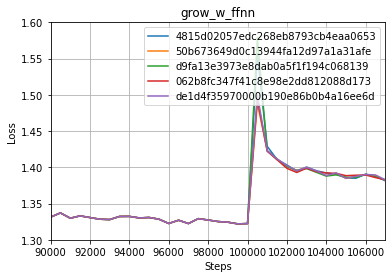

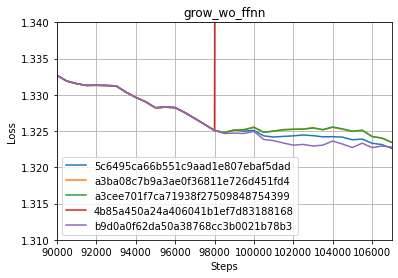

In [28]:
# Plot loss curves of different models
models_dir = '../models'

experiments = ['grow_w_ffnn', 'grow_wo_ffnn']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

for exp in experiments:
    log_histories = {}
    fig, ax = plt.subplots()
    kernel = 10 if exp == 'grow_wo_ffnn' else 1
    for model_hash in os.listdir(os.path.join(models_dir, exp)):
        log_history = json.load(open(os.path.join(models_dir, exp, model_hash, 'log_history.json')))
        ax.plot([state['step'] for state in log_history[:-1]], 
                moving_average([state['loss'] for state in log_history[:-1]], kernel),
                label=model_hash)
    ax.legend()
    ax.set_xlim([90000, 107000])
    if exp == 'grow_w_ffnn': 
        ax.set_ylim([1.3, 1.6])
    else:
        ax.set_ylim([1.31, 1.34])
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    plt.grid()
    ax.set_title(exp)
    plt.show()